##  Compare CMIP6 collections

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [19,4]

import matplotlib.style
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

In [3]:
LDEO_cat = 'https://cmip6.storage.googleapis.com/cmip6-zarr-consolidated-stores.csv'
GFDL_cat = 'https://github.com/aradhakrishnanGFDL/CatalogBuilder/raw/master/intakebuilder/test/intake_uda.csv.gz'
CEDA_cat = 'https://github.com/cedadev/cmip6-object-store/raw/master/catalogs/ceda-zarr-cmip6.csv'

In [4]:
def convert_catalog(csvfile, key = 'path', first = -10, last = -1, separator='/'):
    import pandas as pd 
    csv_catalog = pd.read_csv(csvfile)

    ddict = {}
    for item, tdir in enumerate(csv_catalog[key]):
        #print(item,tdir)
        vlist = tdir.split(separator)[first:last]
        vstore = '/'.join(vlist)+'/'
        vlist += [vstore]
        ddict[item] = vlist

    df = pd.DataFrame.from_dict(ddict, orient='index')
    df = df.rename(columns={0: "activity_id", 1: "institution_id", 2:"source_id",
                            3:"experiment_id",4:"member_id",5:"table_id",6:"variable_id",
                            7:"grid_label",8:"version",9:'vstore'})
    return df

In [5]:
#  read csv file, make the dataset identifiers comparable
dLDEO = pd.read_csv(LDEO_cat, dtype='unicode')
dLDEO['zstore'] = dLDEO.apply(lambda row: row.zstore.split('gs://cmip6/')[-1], axis = 1)
dLDEO['vstore'] = dLDEO.apply(lambda row: row.zstore + 'v' + str(row.version)+'/', axis = 1)
dLDEO = dLDEO.sort_values(by=['version']).drop_duplicates(subset =["zstore"],keep='last')

In [6]:
dGFDL = convert_catalog(GFDL_cat)
dGFDL['zstore'] = dGFDL.apply(lambda row: row.vstore.split(row.version)[0],axis=1)
dGFDL = dGFDL.sort_values(by=['version']).drop_duplicates(subset =["zstore"],keep='last')

In [7]:
dCEDA = convert_catalog(CEDA_cat, key = 'nc_path', first = 5, last = 14)
dCEDA['zstore'] = dCEDA.apply(lambda row: row.vstore.split(row.version)[0],axis=1)
dCEDA = dCEDA.sort_values(by=['version']).drop_duplicates(subset =["zstore"],keep='last')

In [8]:
# Compare number of datasets - for any version
set_L = set(dLDEO.zstore.unique())
set_G = set(dGFDL.zstore.unique())
set_C = set(dCEDA.zstore.unique())
print('LDEO: ',len(set_L),' GFDL:', len(set_G),' CEDA:', len(set_C))

LDEO:  394244  GFDL: 244427  CEDA: 62885


In [9]:
common_LG = sorted(list(set_L.intersection(set_G)))
num_both_LG =   len(set_L)+len(set_G)-len(common_LG)         
common_GC = sorted(list(set_G.intersection(set_C)))
num_both_GC =   len(set_G)+len(set_C)-len(common_GC) 
common_LC = sorted(list(set_L.intersection(set_C)))
num_both_LC =   len(set_L)+len(set_C)-len(common_LC) 

print(len(common_LG),len(common_GC),len(common_LC))
print('In both LDEO and GFDL:',int(100*len(common_LG)/num_both_LG),'%')
print('In both GFDL and CEDA:',int(100*len(common_GC)/num_both_GC),'%')
print('In both LDEO and CEDA:',int(100*len(common_LC)/num_both_LC),'%')

85809 17800 21869
In both LDEO and GFDL: 15 %
In both GFDL and CEDA: 6 %
In both LDEO and CEDA: 5 %


In [10]:
def autolabel(ax,rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',fontsize=10)

In [11]:
def plot_activity(df1,df2,df3,ymax=160000,title_add=''):
    activities = sorted(list( set(df1.activity_id.unique()).union(set(df2.activity_id.unique())).union(set(df3.activity_id.unique())) ))

    vdf1 = []
    vdf2 = []
    vdf3 = []
    names = []
    total = []        
    for activity in activities:
        ndf1 = df1[df1.activity_id==activity].vstore.nunique()
        ndf2 = df2[df2.activity_id==activity].vstore.nunique()
        ndf3 = df3[df3.activity_id==activity].vstore.nunique()
        names += [activity]
        vdf1 += [ndf1]
        vdf2 += [ndf2]
        vdf3 += [ndf3]
        total += [ndf1+ndf2+ndf3]
        #print(activity.ljust(15),str(ndf).ljust(10),str(ndfcat).ljust(10))

    ddict = {'name': names, 'LDEO': vdf1, 'GFDL': vdf2, 'CEDA': vdf3, 'total': total}  

    df_ddict= pd.DataFrame(ddict)   
    df_ddict = df_ddict.sort_values(by=['total'],ascending=False)

    names = df_ddict.name.values[:12]
    vdf1 = df_ddict.LDEO.values[:12]
    vdf2 = df_ddict.GFDL.values[:12]
    vdf3 = df_ddict.CEDA.values[:12]

    x = np.arange(len(names)) 

    width = 0.3  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, vdf1, width, label='LDEO')
    rects2 = ax.bar(x        , vdf2, width, label='GFDL')
    rects3 = ax.bar(x + width, vdf3, width, label='CEDA')
    autolabel(ax,rects1)
    autolabel(ax,rects2)
    autolabel(ax,rects3)
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Number of Datasets')
    ax.set_title('Top 12, By Activity'+title_add)
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.set_ylim([0,ymax])
    ax.legend()

    fig.tight_layout()
    plt.show()

In [12]:
def plot_institution(df1,df2,df3,ymax=160000,title_add=''):
    institutions = sorted(list( set(df1.institution_id.unique()).union(set(df2.institution_id.unique())).union(set(df3.institution_id.unique())) ))

    vdf1 = []
    vdf2 = []
    vdf3 = []
    names = []
    total = []        
    for institution in institutions:
        ndf1 = df1[df1.institution_id==institution].vstore.nunique()
        ndf2 = df2[df2.institution_id==institution].vstore.nunique()
        ndf3 = df3[df3.institution_id==institution].vstore.nunique()
        names += [institution]
        vdf1 += [ndf1]
        vdf2 += [ndf2]
        vdf3 += [ndf3]
        total += [ndf1+ndf2+ndf3]
        #print(activity.ljust(15),str(ndf).ljust(10),str(ndfcat).ljust(10))

    ddict = {'name': names, 'LDEO': vdf1, 'GFDL': vdf2, 'CEDA': vdf3, 'total': total}  

    df_ddict= pd.DataFrame(ddict)   
    df_ddict = df_ddict.sort_values(by=['total'],ascending=False)

    names = df_ddict.name.values[:12]
    vdf1 = df_ddict.LDEO.values[:12]
    vdf2 = df_ddict.GFDL.values[:12]
    vdf3 = df_ddict.CEDA.values[:12]
    
    x = np.arange(len(names)) 

    width = 0.3  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, vdf1, width, label='LDEO')
    rects2 = ax.bar(x        , vdf2, width, label='GFDL')
    rects3 = ax.bar(x + width, vdf3, width, label='CEDA')
    autolabel(ax,rects1)
    autolabel(ax,rects2)
    autolabel(ax,rects3)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Number of Datasets')
    ax.set_title('Top 12, By Institution'+title_add)
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.set_ylim([0,ymax])
    ax.legend()

    fig.tight_layout()
    plt.show()

In [13]:
def plot_frequency(df1,df2,df3,ymax=400000,title_add=''):
    tables = sorted(list( set(df1.table_id.unique()).union(set(df2.table_id.unique())).union(set(df3.table_id.unique())) ))
    freq = ['subhr','hr','3hr','6hr','day','mon','yr','fx']
    dic = {}

    dic['fx'] = ['IfxGre','Ofx','Efx','fx']
    dic['yr'] = ['Oyr','Eyr']

    mons = [match for match in tables if 'mon' in match]
    dic['mon'] = mons

    leftm = list(set(tables) - set(mons))
    days = [match for match in leftm if 'day' in match]
    dic['day'] = days

    leftmd = list(set(leftm) - set(days))
    hr6 = [match for match in leftmd if '6hr' in match]
    dic['6hr'] = hr6

    leftmd6= list(set(leftmd) - set(hr6))
    hr3 = [match for match in leftmd6 if '3hr' in match]
    dic['3hr'] = hr3

    leftmd63= list(set(leftmd6) - set(hr3))
    hr = [match for match in leftmd63 if 'hr' in match]
    dic['hr'] = hr

    dic['other'] = ['Odec','SIclim','Aclim','Oclim','Eclim']
    
    vdf1 = []
    vdf2 = []
    vdf3 = []
    names = [] 

    for freq in dic.keys():
        ndf1 = 0
        ndf2 = 0
        ndf3 = 0
        for table in dic[freq]:
            ndf1 += df1[df1.table_id==table].vstore.nunique()
            ndf2 += df2[df2.table_id==table].vstore.nunique()
            ndf3 += df3[df3.table_id==table].vstore.nunique()
        names += [freq]
        vdf1 += [ndf1]
        vdf2 += [ndf2]
        vdf3 += [ndf3]

    x = np.arange(len(names)) 

    width = 0.3  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, vdf1, width, label='LDEO')
    rects2 = ax.bar(x        , vdf2, width, label='GFDL')
    rects3 = ax.bar(x + width, vdf3, width, label='CEDA')
    autolabel(ax,rects1)
    autolabel(ax,rects2)
    autolabel(ax,rects3)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Number of Datasets')
    ax.set_title('By Frequency'+title_add)
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.set_ylim([0,ymax])
    ax.legend()

    fig.tight_layout()
    plt.show()

## Basic Statistics on the three archives



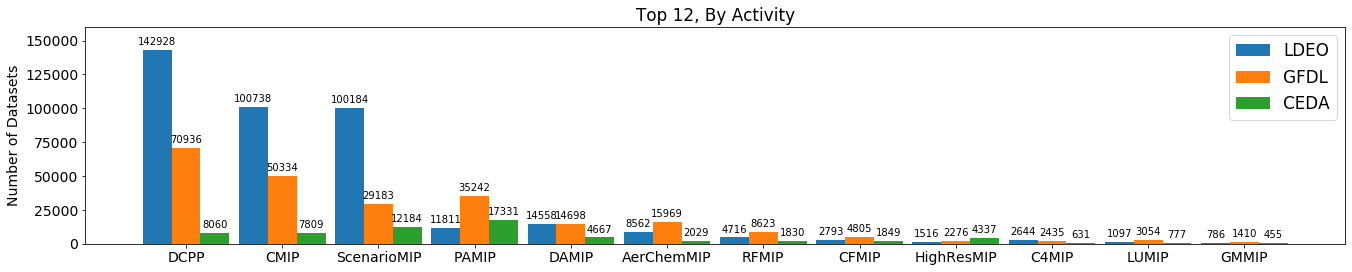

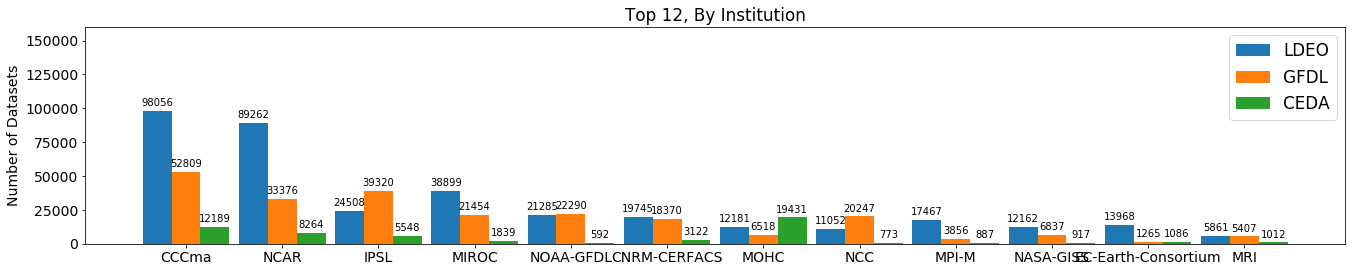

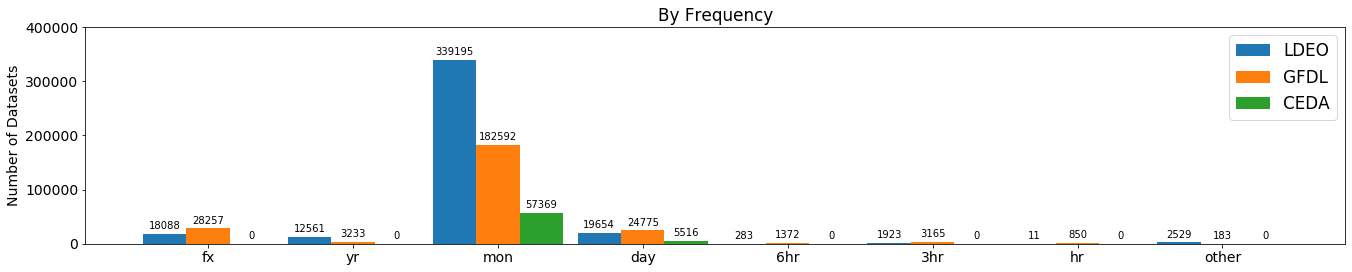

In [14]:
plot_activity(dLDEO,dGFDL,dCEDA)

plot_institution(dLDEO,dGFDL,dCEDA)

plot_frequency(dLDEO,dGFDL,dCEDA)

## DCPP has many, many short monthly datasets
- Pangeo-GC collected them primarily for CCCma and NCAR, but then stopped
- GFDL-ESGF has many fewer

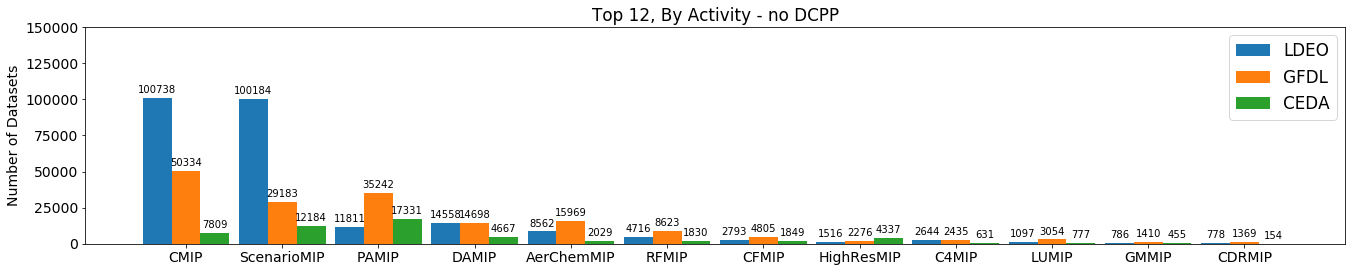

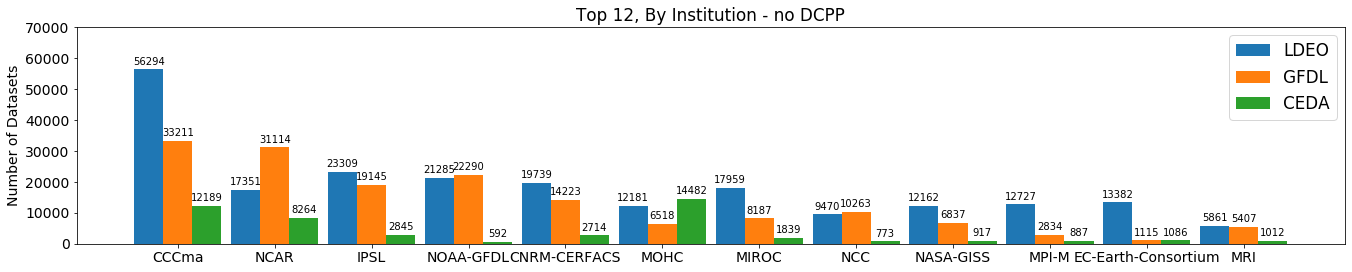

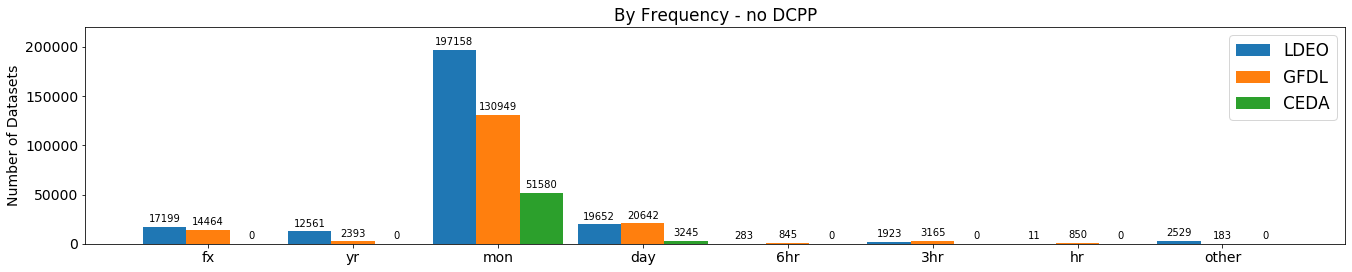

In [15]:
d1 = dLDEO[dLDEO.activity_id != 'DCPP']
d2 = dGFDL[dGFDL.activity_id != 'DCPP']
d3 = dCEDA[dCEDA.activity_id != 'DCPP']

plot_activity(d1,d2,d3,ymax=150000,title_add=' - no DCPP')
plot_institution(d1,d2,d3,ymax=70000,title_add=' - no DCPP')
plot_frequency(d1,d2,d3,ymax=220000,title_add=' - no DCPP')